# Exploring Dutch lockdown tweets during COVID-19

***
The main goal of this notebook is to set up a project that allows us to explore**Dutch** tweets during the the COVID-19 crisis. We will discuss the process starting from data collection to a small set of possible analyses with this kind of data. 

Roughly speaking, we can divide this process in:
1. setting up a mysql database to collect and store tweets based one or more keywords
2. accessing the database and prepare it for analysis in Python 
3. analyse data using:
    - topic modeling
    - sentiment analysis
    - network analysis (hashtag co-occurence networks)
    
**Note** that this is by no means a comprehensive guide on either subject nor will I provide in-depth interpretations of the results that come up. I merely stroke some interesting topics that merit an in-depth exploration on their own. Therefore, I also add some hyperlinks to extra material where relevant. 

## Setting up the database and collecting data based on the keyword 'lockdown'

Setting up the database in mysql is done through the MYSQL Connector/Python. More information on this can be found <a href="https://dev.mysql.com/doc/connector-python/en/">here</a>. The connector essentially is "a self-contained Python driver for communicating with MySQL servers". <br><br> If you are interested in details on the code itself, you can check out my <a href="https://github.com/FrederikDeGrove/twitter_streaming">GitHub page </a>. <br><br> To collect the Twitter streaming data we created a class called MyStreamlistener that builds on the Streamlistener provided by the <a href= "https://www.tweepy.org/">Tweepy library</a>. <br>
If you want to run the code to collect Twitter streaming data for a specific keyword you will need to download the GitHub code and you should additionally create two extra files in the directory where you stored the main.py file. In short, to make this code work, you will need:
1. a file named **keys.txt** with your twitter API developer credentials in the following order:
    - consumer key
    - consumer secret
    - API key
    - API secret
   
2. a file named **db.txt** with the following login information for your database in the following order: 
    - host name
    - database name
    - user name
    - password
    
3. Python libraries (installed with pip or equivalent)
    - pandas
    - tweepy
    - sqlalchemy.exc
    - mysql.connector
    - time
    
4. an installation of MYSQL server. You can follow this <a href="https://www.digitalocean.com/community/tutorials/how-to-install-mysql-on-ubuntu-18-04"> guide </a> to install MYSQL server on an UBUNTU machine.

<br>
Once you have set up these requirements, you can use the code in the next snippet to start your collection of streaming data based on one or several keywords. Running the code will prompt you to provide a **keyword** (if using more than one keyword, make sure to separate them with a comma) and a **name for the table** in which your data will be stored.
<br><br>
As the Tweepy streamlistener will keep collecting tweets, we included an option to use a **time limit**. For this example we collect streaming data for 30 seconds on the **lockdown** keyword. We store our data in the table named **corona_table**. If this table does not exist, a new one will be created. If it does exist, data will be added to the table. 

In [1]:
import tweepy
import mysql.connector
from mysql.connector import Error
import pandas as pd 

In [2]:
import main
stream_listener = main.MyStreamListener(
    time_limit=30, 
    table_name=main.tab_name,
    keys=main.keys)
stream = tweepy.Stream(auth=stream_listener.api.auth, 
                       listener=stream_listener)
stream.filter(track=[main.keyword])

Please provide one or more keywords (comma separated): lockdown
Please provide a name for the table in which your data will be stored: corona_table
Table created successfully 
Connected to MySQL Server version  5.7.29-0ubuntu0.18.04.1
You're connected to database:  corona
Record inserted successfully into table
Record inserted successfully into table


## Reading data from the MYSQL database and preparing it for analysis

<br>
Our main goal here is to extract the necessary data from the MYSQL database into a format that allows us to do some data wrangling operations so our data are ready for analysis. 
<br><br>
In the first place, we will use the MYSQL Connector/Python again to access our table. By running the next code snippet, we access our **db.txt** file (see above) and then we try to connect to the database specified in our text document. If all goes well, you should receive a message that you are connected to your database.

In [3]:
db = open("db.txt", "r").readlines()
try:
    connection = mysql.connector.connect(
        host= db[0].strip(),
        database=db[1].strip(),
        user=db[2].strip(),
        password=db[3].strip()
    )
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database named:", record[0])
except Error as e:
        db_Info = connection.get_server_info()

Connected to MySQL Server version  5.7.29-0ubuntu0.18.04.1
You're connected to database named: corona


<br> Once we are connected we can submit MYSQL queries via Python. So let us have a look at the structure of our table by using the `DESCRIBE` command on our previously stored table. <br><br>
This returns the same information as the desribe table command would do in MYSQL. It gives basic information on the variables stored in the table such as their name and type. However, the table is quite messy. Let's see how we can improve this.
<br> <br>
**Note** From now on, I will be using data that were collected over a period of several days instead of for a number of seconds demonstrated above. The table I will be using is called **corona2** <br>

In [4]:
cursor = connection.cursor()
collect_data_sql = "DESCRIBE corona2"
cursor.execute(collect_data_sql)
data = [item for item in cursor]

This yields a list of tuples which we convert to a dataframe using the pd.DataFrame.from_records() function. We also drop the varialbes that we are not interested in using the pd.drop function. This yields the following table.

In [232]:
df = pd.DataFrame.from_records(data, columns =['Variable', 'Type', 'Null', 'Key', 'Default', 'Extra'])
df = df.drop(['Default', 'Extra', 'Key', 'Null'], axis=1)
df

,Variable,Type
0,Id,varchar(100)
1,text,varchar(1024)
2,Name,varchar(250)
3,tweet_date,date
4,followers,int(20)
5,friends,int(20)
6,coords,varchar(250)
7,user_created,date
8,verified,tinyint(1)
9,retweets,int(20)


Now that we have an idea about the structure of our table, we can import our data. The procedure is the same as above. We construct a MYSQL query and `SELECT` all data we need from our table. We store it as a list and convert it to a Pandas dataframe.

In [233]:
cursor = connection.cursor()
collect_data_sql = "SELECT * FROM corona2"
cursor.execute(collect_data_sql)
full_data = [item for item in cursor]
df2 = pd.DataFrame.from_records(full_data, columns =list(df.Variable))
df2 = df2.astype({
                  'Id':'object', 'text':'object', 'Name':'object',
                  'tweet_date':'datetime64', 'followers':'int64',
                  'friends':'int64', 'coords':'object', 
                  'user_created':'object', 'verified':'bool', 
                  'retweets':'int64'
                 })
df2[['Id', 'tweet_date', 'text']].head()

,Id,tweet_date,text
0,1252599646511300608,2020-04-21,RT @KwaggaBoucher: Wat dink julle van 'n lockd...
1,1252599706422829056,2020-04-21,RT @MerlotVine: Draad.\nDringend aanbevolen. ⬇...
2,1252599772546052097,2020-04-21,Een riedel die de laatste tijd veel de ronde d...
3,1252599854397902848,2020-04-21,RT @NewWineNL: Vacature Eventmanager New Wine ...
4,1252599896118644737,2020-04-21,So maklik...nou wonder ek...hoekom koop ons bi...


## Data analysis

In the previous part, we prepared our data for analysis. In this part we will deal with:
1. Data exploration
2. Data pre-processing
3. Topic modeling
4. Sentiment analysis
5. Co-hashtag analysis

We will use the following libraries:
- matplotlib
- sklearn
- pattern
- nltk
- seaborn
- numpy
- xml
- math
- networkx
- pandas


### Data exploration

Data exploration is arguably the most important and time consuming part of any data analysis. The **pandas** library offers a lot of interesting functionalities to wrangle data. In addition, we will be using `matplotlib.pyplot` and `seaborn` libraries for visualiations.

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
#sns.set(color_codes=True)
font = {'family' : 'DejaVu Sans',
        'size'   : 20}
style.use('ggplot')
plt.rcParams['figure.figsize'] = [30, 20]
plt.rc('font', **font)

Let's have a look at the shape of our dataset using the `shape` function. We will also check if there is are any missings for each of our variables. This can be done in several ways. Using the `count` method of a pandas dataFrame counts the number of non-missing values.

In [235]:
print("Our dataset has {} rows and {} columns.\n".format(df2.shape[0], df2.shape[1])) 
print("The number of non-missing values for each column is: " + "\n" + str(df2.count()))


Our dataset has 71770 rows and 10 columns.

The number of non-missing values for each column is: 
Id              71770
text            71770
Name            71770
tweet_date      71770
followers       71770
friends         71770
coords          71770
user_created    71770
verified        71770
retweets        71770
dtype: int64


Next, it is important to consider that there might be tweets in our dataset that originate from the same person. If such duplicates exist, we should be careful in reporting e.g., the mean number of friends or followers of the profiles in our dataset. Using the `nunique` function, we see that we have a lot less unique profiles compared to the total amount of tweets. We create a new table containing profile information in order to get a correct idea about the distrbiubtion of user related variables such as the number of friends. 

In [236]:
print("The number of unique profiles in dataset is {}".format(df2.Name.nunique()))

The number of unique profiles in dataset is 31111


In [237]:
df_unique = df2.drop_duplicates(subset="Name")
df_unique = df_unique.drop(["Id", "text", "tweet_date", "retweets"], axis=1)
df_unique.shape

(31111, 6)

In [238]:
print("The mean number of followers is {}".format(int(df_unique.followers.mean())), 
      "(sd={}).".format(int(df_unique.followers.std())), 
      "while the maximum number of followers is {}".format(int(df_unique.followers.max())), "\n"
      "The mean number of friends is {}".format(int(df_unique.friends.mean())), 
      "(sd={})".format(int(df_unique.friends.std())),
      "while the maximum number of friends is {}".format(int(df_unique.friends.max())))

The mean number of followers is 1852 (sd=20251). while the maximum number of followers is 1702734 
The mean number of friends is 768 (sd=1759) while the maximum number of friends is 81716


Considering the mean number of friends and followers and especially their standard deviation, we can expect a skewed distribution for both variables (which is not uncommon for internet data). We use `distplot` to plot the distribution of both variables. We limit our data to the 95th percentile to avoid an extremely skewed plot. <br>
As expected, these distributions show us that most accounts have a small number of friends and followers whereas only a few accounts have a lot of followers or friends. 

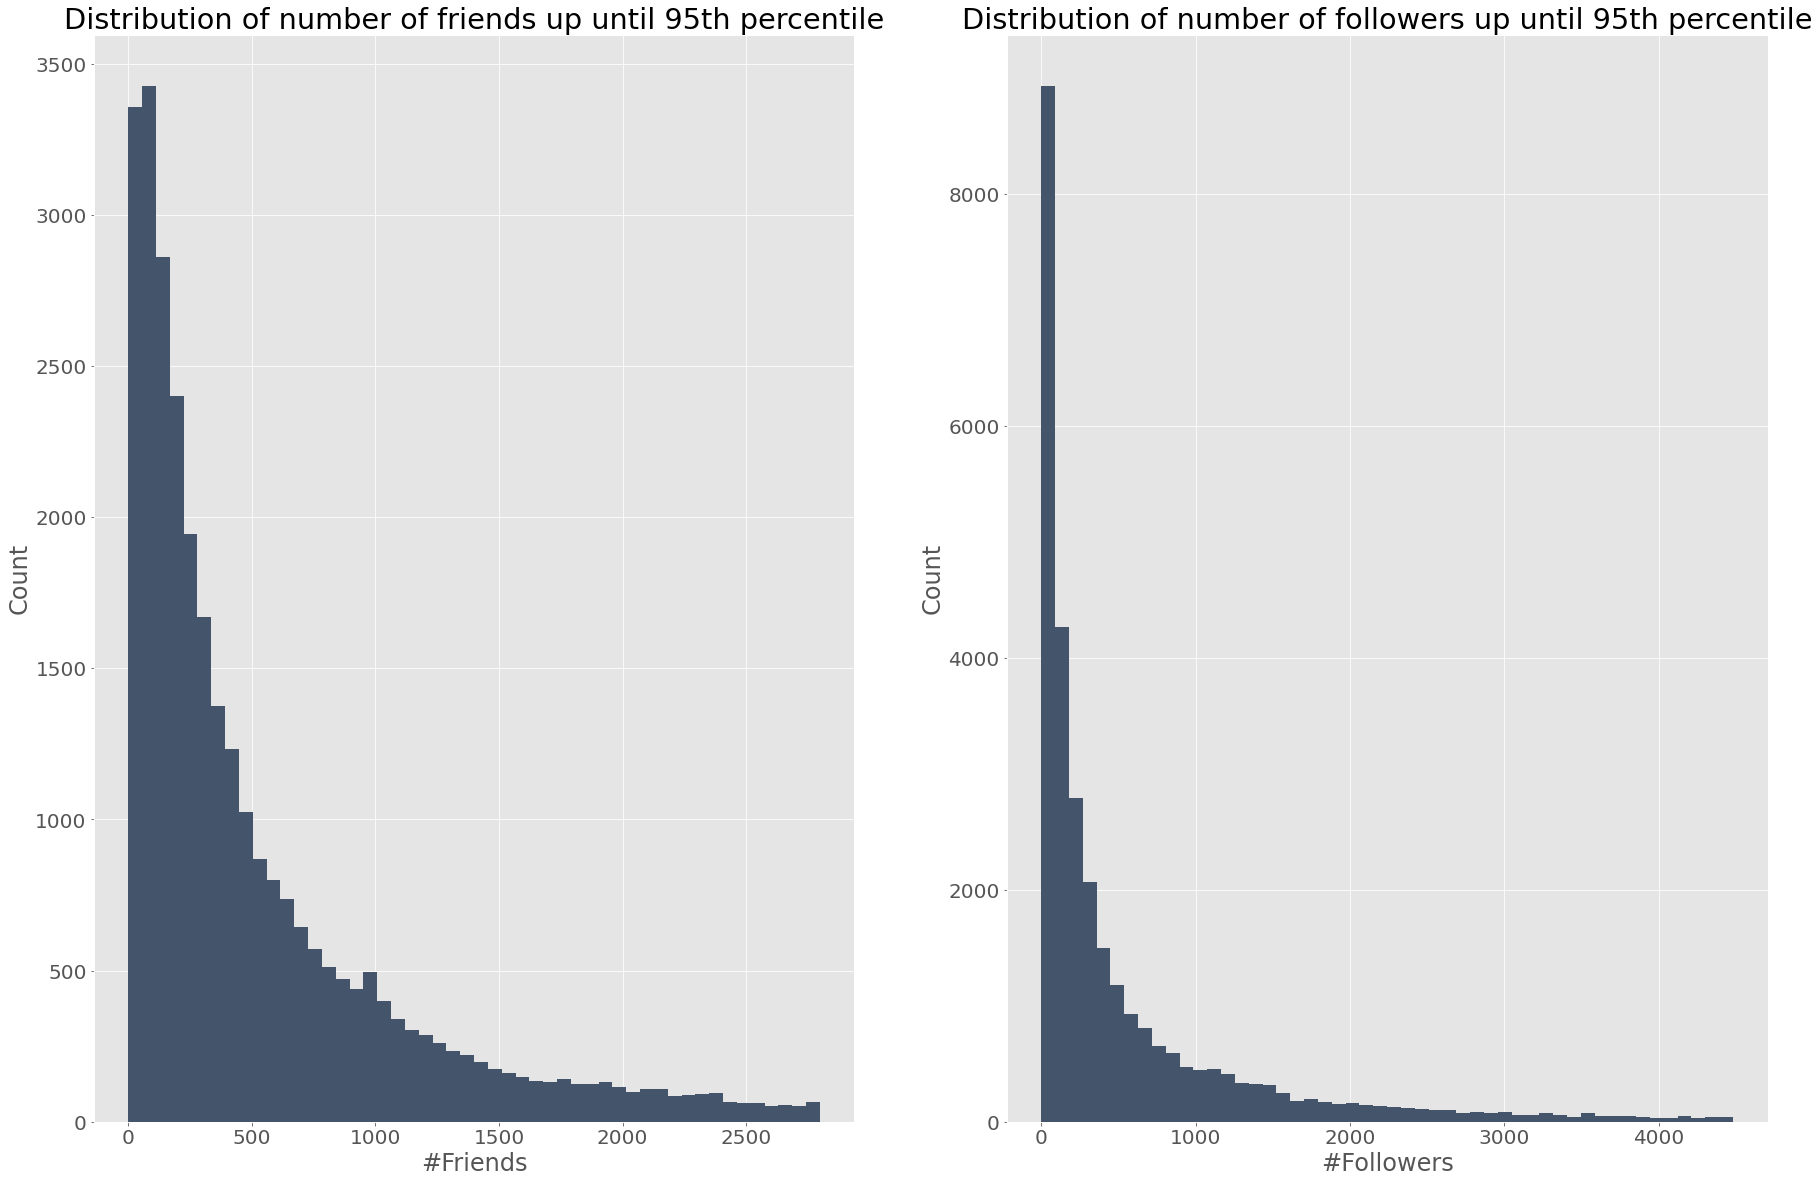

In [239]:
fig, ax =plt.subplots(1,2)
sns.distplot(df_unique.friends[df_unique.friends 
             < df_unique.friends.quantile(0.95)], 
             kde=False, color="#44546A",
             hist_kws={"alpha":1}, ax=ax[0]
            ).set(title = 'Distribution of number of friends up until 95th percentile',
                                      xlabel = '#Friends', 
                                      ylabel = 'Count');
sns.distplot(df_unique.followers[df_unique.followers < 
             df_unique.followers.quantile(0.95)], kde=False, color="#44546A",
             hist_kws={"alpha":1}, ax=ax[1]
            ).set(title = 'Distribution of number of followers up until 95th percentile',
                                      xlabel = '#Followers', 
                                      ylabel = 'Count');
plt.show()

For these user accounts, we can also look when they were created. Although we have specific dates regarding account creation, we are only interested in the year of their creation (`dt.strftime`). We use a `catplot` combined with `kind=count` to create a boxplot that shows us the number of accounts created for each year.
<br>
We see a stong increase in the number of accounts that were created (and that tweeted using 'lockdown') from 2009 onwards. 

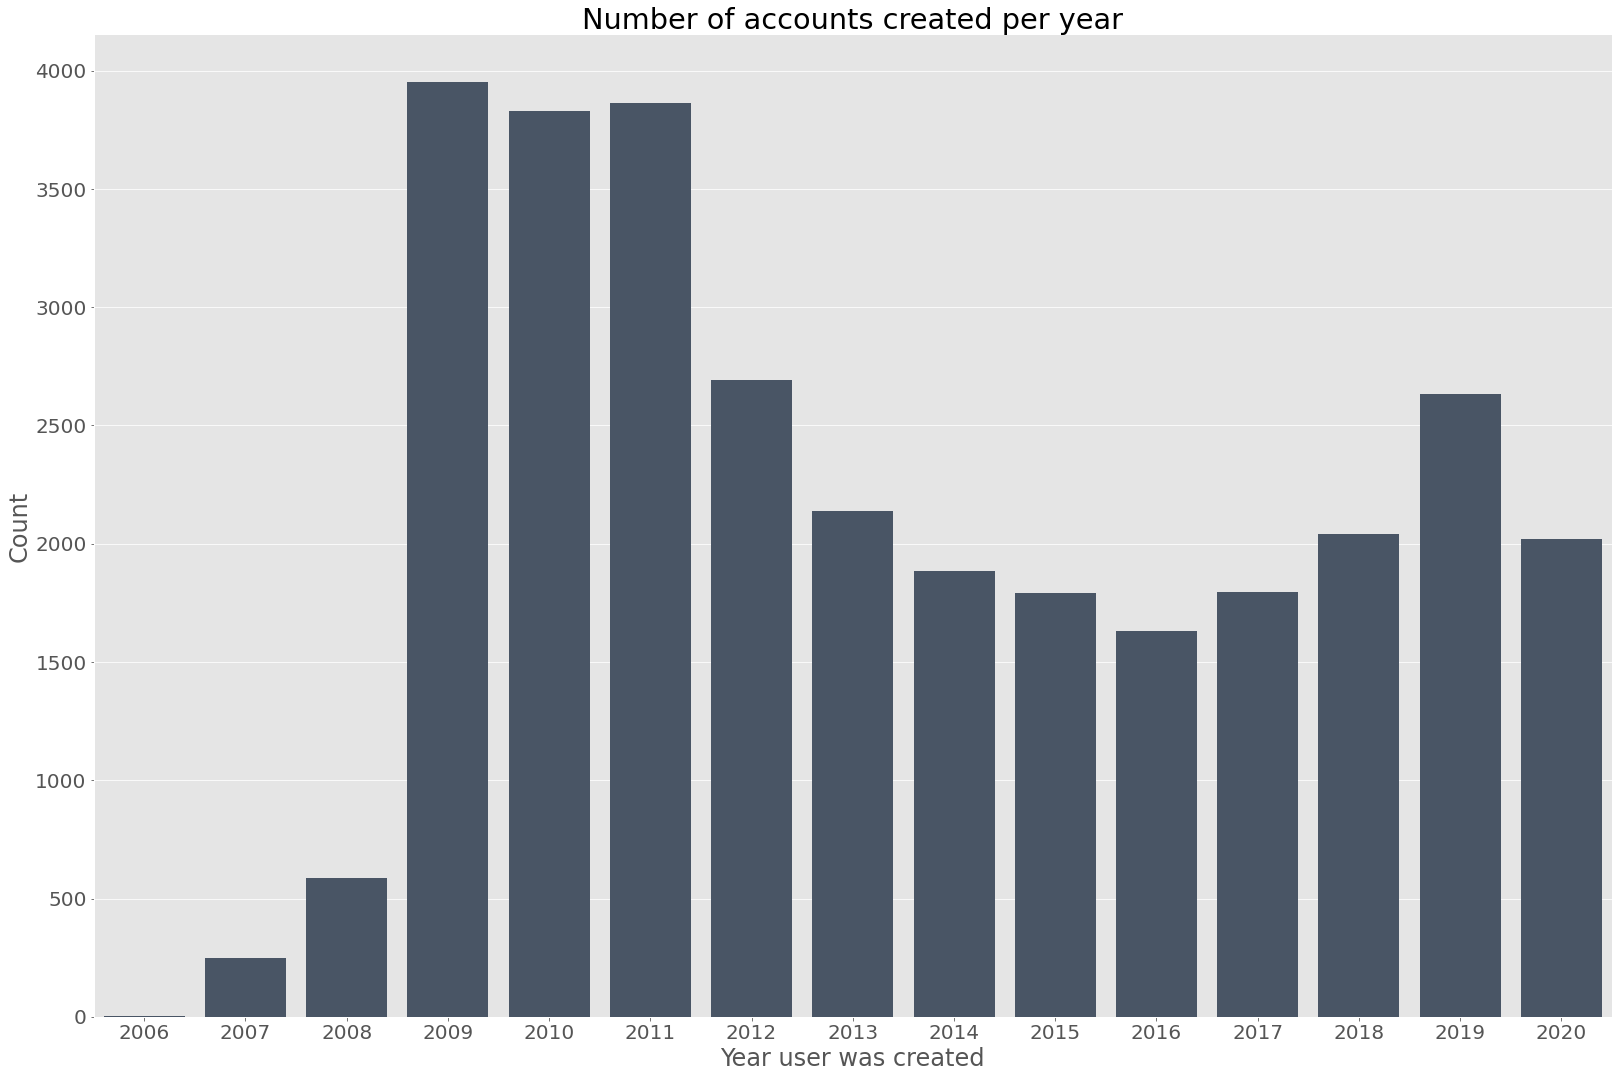

In [240]:
year_creation = pd.to_datetime(df_unique.user_created).dt.strftime("%Y")
df_unique.insert(loc = 0 ,column = "year_creation", value = year_creation)
sns.catplot("year_creation", kind="count", color="#44546A", height=15, 
            aspect=1.5, data=df_unique).set(title = 'Number of accounts created per year',
                                      xlabel = 'Year user was created', 
                                      ylabel = 'Count');

Now, let's have a look at the number of days we collected data (`unique()`) and how many tweets were sent during each day (`value_counts()`). 

In [241]:
print('the number of days in the dataset is ' + str(len(df2.tweet_date.unique())) + "\n")
print("the unique dates and the number of tweets per date in the dataset are: \n")
x = df2.tweet_date.value_counts()
x = pd.DataFrame(x)
x.columns = ["Number of tweets"]
x.sort_index()

the number of days in the dataset is 13

the unique dates and the number of tweets per date in the dataset are: 



,Number of tweets
2020-04-21,3877
2020-04-22,7411
2020-04-23,5606
2020-04-24,5143
2020-04-25,5128
2020-04-26,7203
2020-04-27,5257
2020-04-28,8174
2020-04-29,5251
2020-04-30,4324


Equivalently, we can create a boxplot (`catplot`) showing us the distribtuion of tweets per day. 

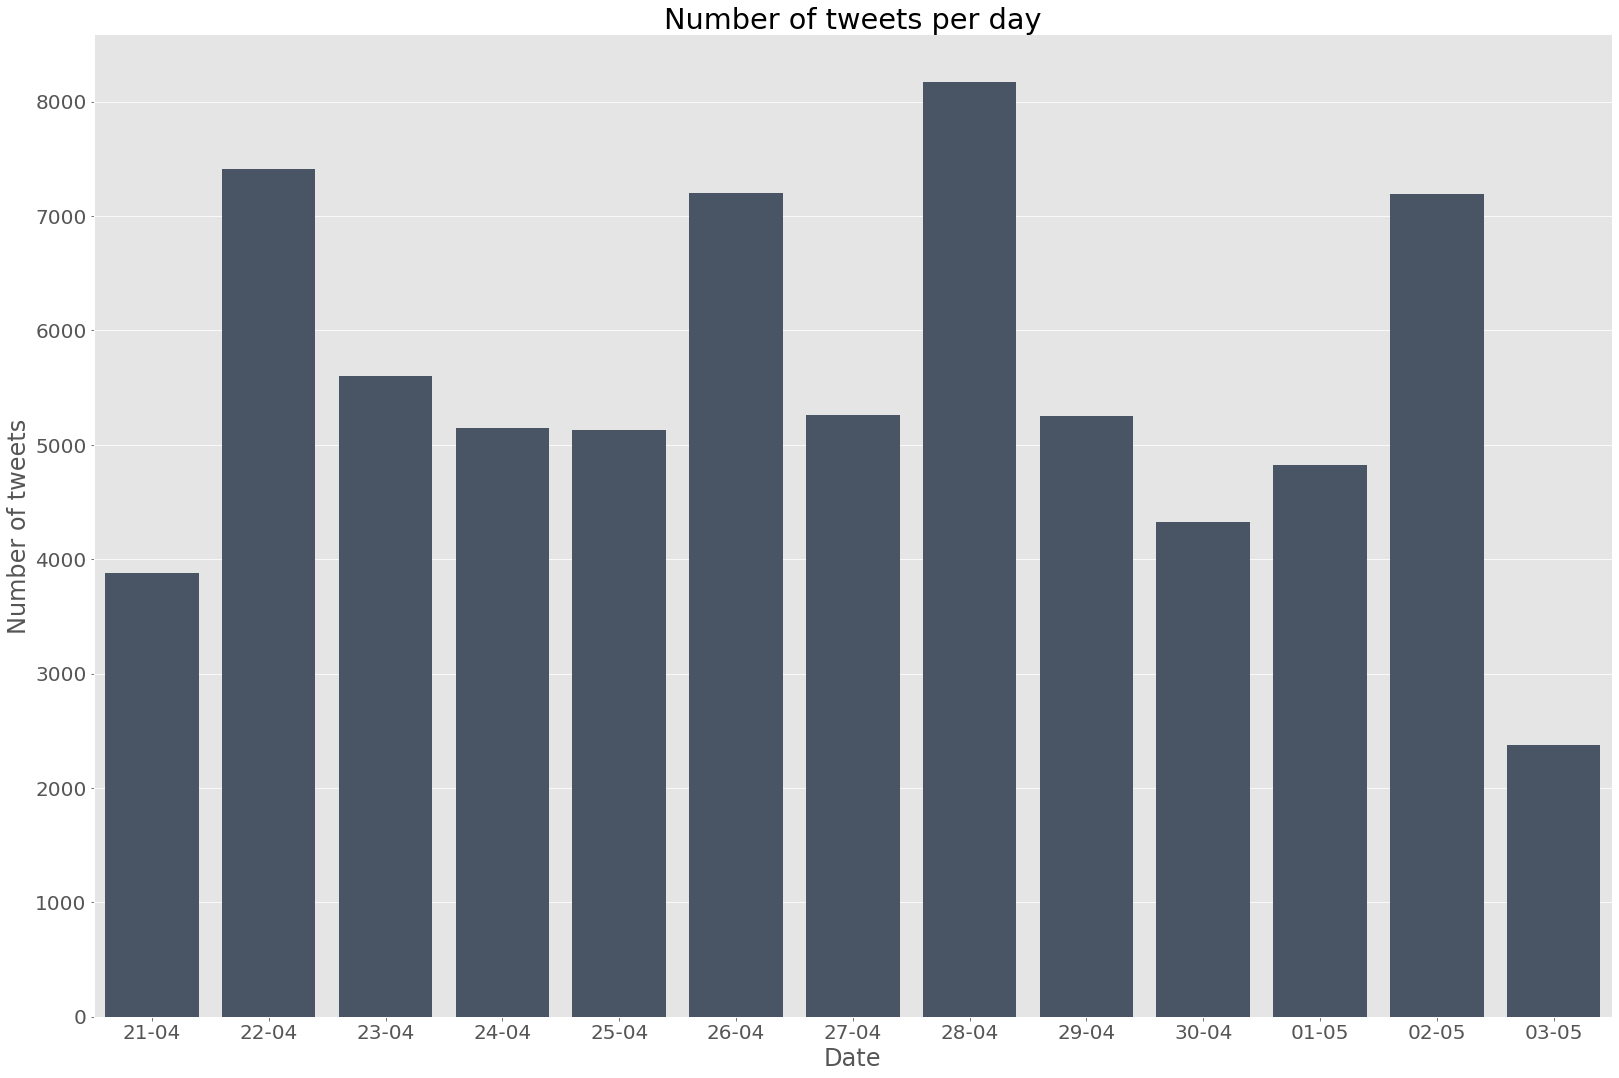

In [242]:
df2.tweet_date = pd.to_datetime(df2.tweet_date).dt.strftime('%d-%m')
sns.catplot("tweet_date", kind="count", color="#44546A", height=15, 
            aspect=1.5, data=df2).set(title = 'Number of tweets per day',
                                      xlabel = 'Date', 
                                      ylabel = 'Number of tweets');

### Data pre-processing

So, by exploring our data we had a first idea of what it looks like. To perform analyses involving textual data, we will first need to pre-process our data. This involves procedures such as tokenizing, lemmatizing and converting text to vector representations and so on. 
<br>
So we will start by reading in our data and tokenizing it. In tis case, this means that we will chop each tweet up in separate words (tokens). We will use the `TweetTokenizer` function from the `nltk` library to do so. This function has some neat methods. For example, it allows you to choose whether you want to strip the handles from the tweets text. 
<br>
Next, we will define some functions -some based on the `pattern` library - that will help us normalize and lemmatize our tokens. 
More specifically, these functions will allow us to:
- remove words that are considered to be too short,
- remove stopwords based on the nltk library,
- set all words to lowercase,
- to replace characters when needed. Especially line breaks and 
  the occurence of the word 'lockdown',
- lemmatize words based on the pattern library.


In [243]:
from nltk.tokenize import TweetTokenizer
import pattern
import pattern.nl
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

In [244]:
def remove_words_of_length(dat, length=2):
    to_pop = []
    for word in dat.split(" "):
        if len(word) <= length and has_digits(word) < 1:
            to_pop.append(word)
    words = [i for i in dat.split(" ") if i not in to_pop]
    return ' '.join(words)

def remove_stopwords(text, stopword_list):
    t = text.split(" ")
    keepers = [i for i in t if i not in stopword_list]
    return ' '.join(keepers)

def set_lowercase(text):
    return ''.join([i.lower() for i in text])

def custom_lemmatize(text_):
    return ' '.join(pattern.text.Sentence(pattern.nl.parse(text_, lemmata=True)).lemmata)

def replace_characters(char_dict, text):
    to_change = text
    for key, value in char_dict.items():
        to_change = to_change.replace(key, value)
    return to_change

def has_digits(text):
    # takes a string counts the number of digits for each element in the string
    return sum(1 for i in text if i.isdigit())

In [245]:
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
tweets = df2.text
word_tokens = [' '.join(tknzr.tokenize(sent)) for sent in tweets]
word_tokens_ = [remove_words_of_length(i, length=2) for i in word_tokens]
word_tokens_ = [set_lowercase(i) for i in word_tokens_] 
word_tokens_ = [remove_stopwords(i, stopwords.words('dutch')) for i in word_tokens_]
to_replace = dict({"lockdown": ' ', 'https': ' ', '\n': ' ', '#': ' '})
word_tokens_= [replace_characters(to_replace, i) for i in word_tokens_]
word_tokens_ = [custom_lemmatize(i) for i in word_tokens_] 

In [366]:
df3 = pd.concat([df2, pd.Series(word_tokens_, name="tokens")], axis = 1)

So, this concludes our text pre-processing. Let's compare a raw tweet in our dataset with a pre-processed one.

In [251]:
print("----------------------------------------------------------")
print("The raw tweet looks like this: \n\n" + df2.text[100] + "\n")
print("----------------------------------------------------------")
print("The processed tweet looks like this: \n\n" + word_tokens_[100])
    

----------------------------------------------------------
The raw tweet looks like this: 

@GeertCu @jjverhels Op dit moment zou ik hem niet goed onderhouden durven noemen. Voor de lockdown ging ik om de zoveel tijd bij de barbier langs.

----------------------------------------------------------
The processed tweet looks like this: 

moment goed onderhouden durven noemen gaan zoveel tijd barbier langs


### Topic modeling

In this part we are looking to classify tweets based on some common topics they share. We use Latent Dirichlet Allocation which can be considered unsupervised learning as we provide no a-priori classes (topics). Broadly speaking, the method will look for similarities (joint probabilities) between tweets (documents) and the words they contain. Topics are in essence a collection of words that together represent a topic. Each tweet can belong to more than one topic although some topic are more present (probable) than others. A 'downside' of this method is that we have to determine the number of topics we expect there to be in our corpus. There are several ways to do this such as lookin at the Perplexity or Coherence score but we will not address this issue at this time and just arbitrarily pick a number of topics. We will also be using the LDA function that is included in the `sklearn` library but note that there are different options such as provided by the `gensim` library.    

In [252]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

As we did not check for dubplicated tweets yet (e.g. through retweeting) we will first do so now.

In [367]:
#x = pd.Series(word_tokens_).drop_duplicates()
df3 = df3[df3.tokens.duplicated() == False]
df3 = df3[df3.tokens.isna() == False]
word_tokens_ = pd.Series(df3.tokens)

Next, we vectorize our sentences. In essence this boils down to creating a number for each unique word and in the case of the `CountVectorizer` we count how many times each word appears in a tweet. Hence, this yields a sparse matrix with the number of tweets as the rows and the number of unique words as the columns. Cell values represent the count of each word for a tweet.

In [259]:
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(word_tokens_)

In [260]:
print("Our vectorized dataset has {} rows and {} columns.".format(data_vectorized.shape[0], 
                                                                  data_vectorized.shape[1]))

Our vectorized dataset has 38004 rows and 41431 columns.


Let's see what the most frequent words are in our dataset.

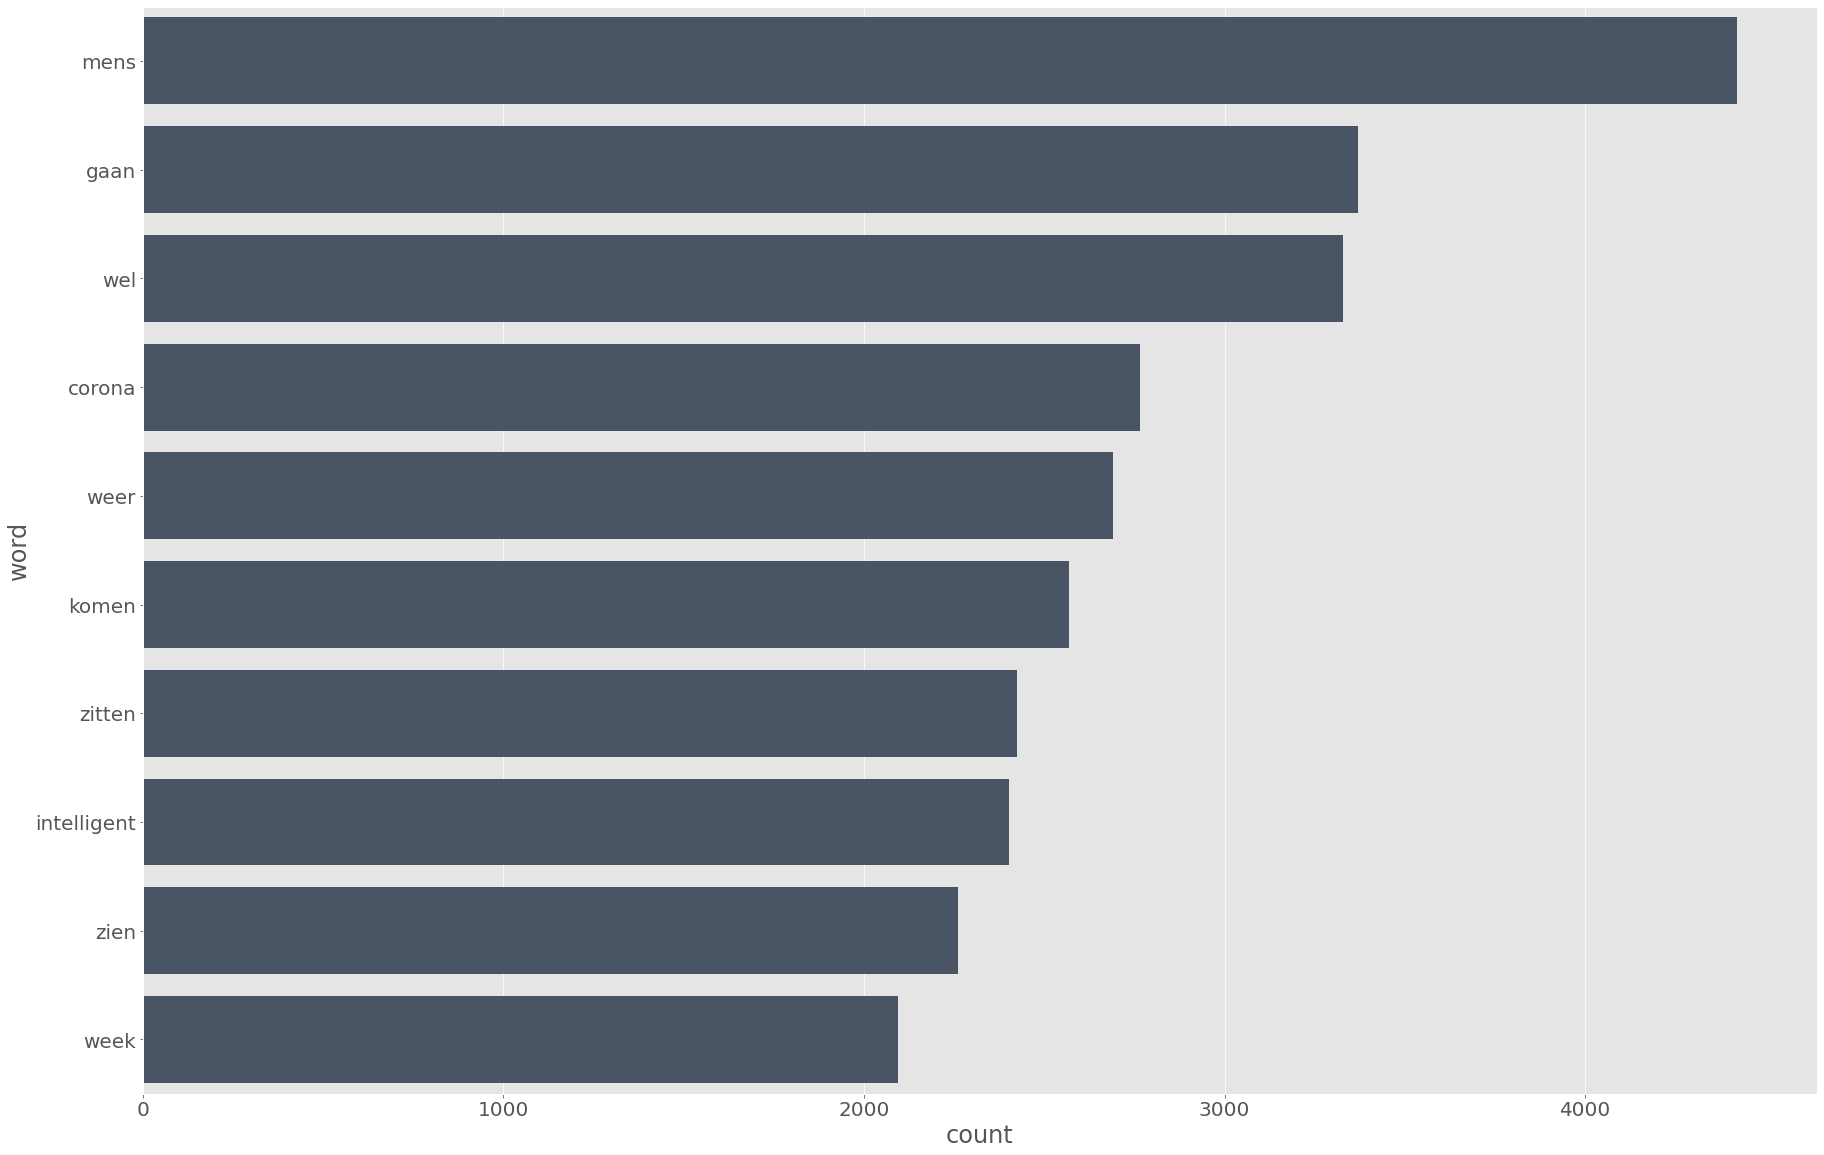

In [261]:
word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 
                           'count': np.asarray(data_vectorized.sum(axis=0))[0]})

sns.barplot(x='count', y='word', 
            data=word_count.sort_values(by="count", ascending = False)[0:10], color='#44546A');

At this point, our data are ready to be submitted to the `LatentDirichletAllocation` function. We decide to pick 10 topics and do not chance any of the other parameters in the model. 

In [262]:
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(data_vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

As mentioned before, each topic is a combination of words. Each word contributes to some extent to determining the topic. Let's have a look at the top 10 words for each topic. Based on the most important words, one usually names each topic. In this example, coming up with clear-cut names is not always possible. At this point, however, we will use these topics in a data driven way to look at possible differences when it comes to sentiment.     

In [263]:
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_nr, topic in enumerate(model.components_):
        message = "\nTopic %d: " % topic_nr
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
print_top_words(lda, vectorizer, n_top_words=10)


Topic 0: zweed test land goed wel maatregel corona besmetting aantal gaten

Topic 1: intelligent weer mogen open komen wel mei gaan week corona

Topic 2: mens echt intelligent stoppen doen corona dag lezen zitten denken

Topic 3: wel corona komen mens maken zien gaten gaan week laten

Topic 4: gaan mens heel zien zitten virus weer moeten komen echt

Topic 5: mens blijven wel doden moeten jaar zeggen 000 doen echt

Topic 6: mens houden week gaan willen zitten corona staan gaten weer

Topic 7: dag staan zien tijdens mens krijgen zitten alleen gaan mogen

Topic 8: ni gaan vir 19 covid jou mens nou komen hul

Topic 9: zitten stoppen onze weer laten vrijheid maken week fvd blijven



Additionally, we can have a look -for each tweet- at the probability to belong to a certain topic. We do so for the first five tweets. 

In [264]:
doc_topic_dist = pd.DataFrame(lda.transform(data_vectorized))
doc_topic_dist.head(5)

,0,1,2,3,4,5,6,7,8,9
0,0.008334,0.008334,0.008335,0.008335,0.008333,0.008334,0.008334,0.008335,0.924994,0.008334
1,0.336060,0.009092,0.009094,0.009092,0.009092,0.591197,0.009097,0.009092,0.009094,0.009092
2,0.005558,0.005557,0.005557,0.456493,0.499053,0.005557,0.005557,0.005557,0.005556,0.005556
3,0.007693,0.930755,0.007695,0.007693,0.007695,0.007694,0.007693,0.007693,0.007695,0.007693
4,0.014286,0.014287,0.323175,0.014288,0.014292,0.014287,0.014286,0.014286,0.562523,0.014291


Based on these probabilities, we can decide to assign each tweet to a cluster. In this case, we just assign each tweet to the topic that scores highest.

In [364]:
topicNumber = pd.DataFrame(doc_topic_dist.idxmax(axis=1), columns = ["topicNumber"])
topicScores = pd.DataFrame(doc_topic_dist.max(axis=1), columns = ["topicScore"])
topics = pd.concat([topicNumber,topicScores], axis=1)
#topics.columns = ['topicNumber', 'topicScore']

In [365]:
topics

,topicNumber,topicScore
0,8,0.924994
1,5,0.591197
2,4,0.499053
3,1,0.930755
4,8,0.562523
...,...,...
37999,3,0.619171
38000,5,0.935704
38001,0,0.601393
38002,0,0.672967


In [368]:
df3 = df3.reset_index()
topics.reset_index()
df3 = pd.merge(df3, topics, left_index=True, right_index=True)

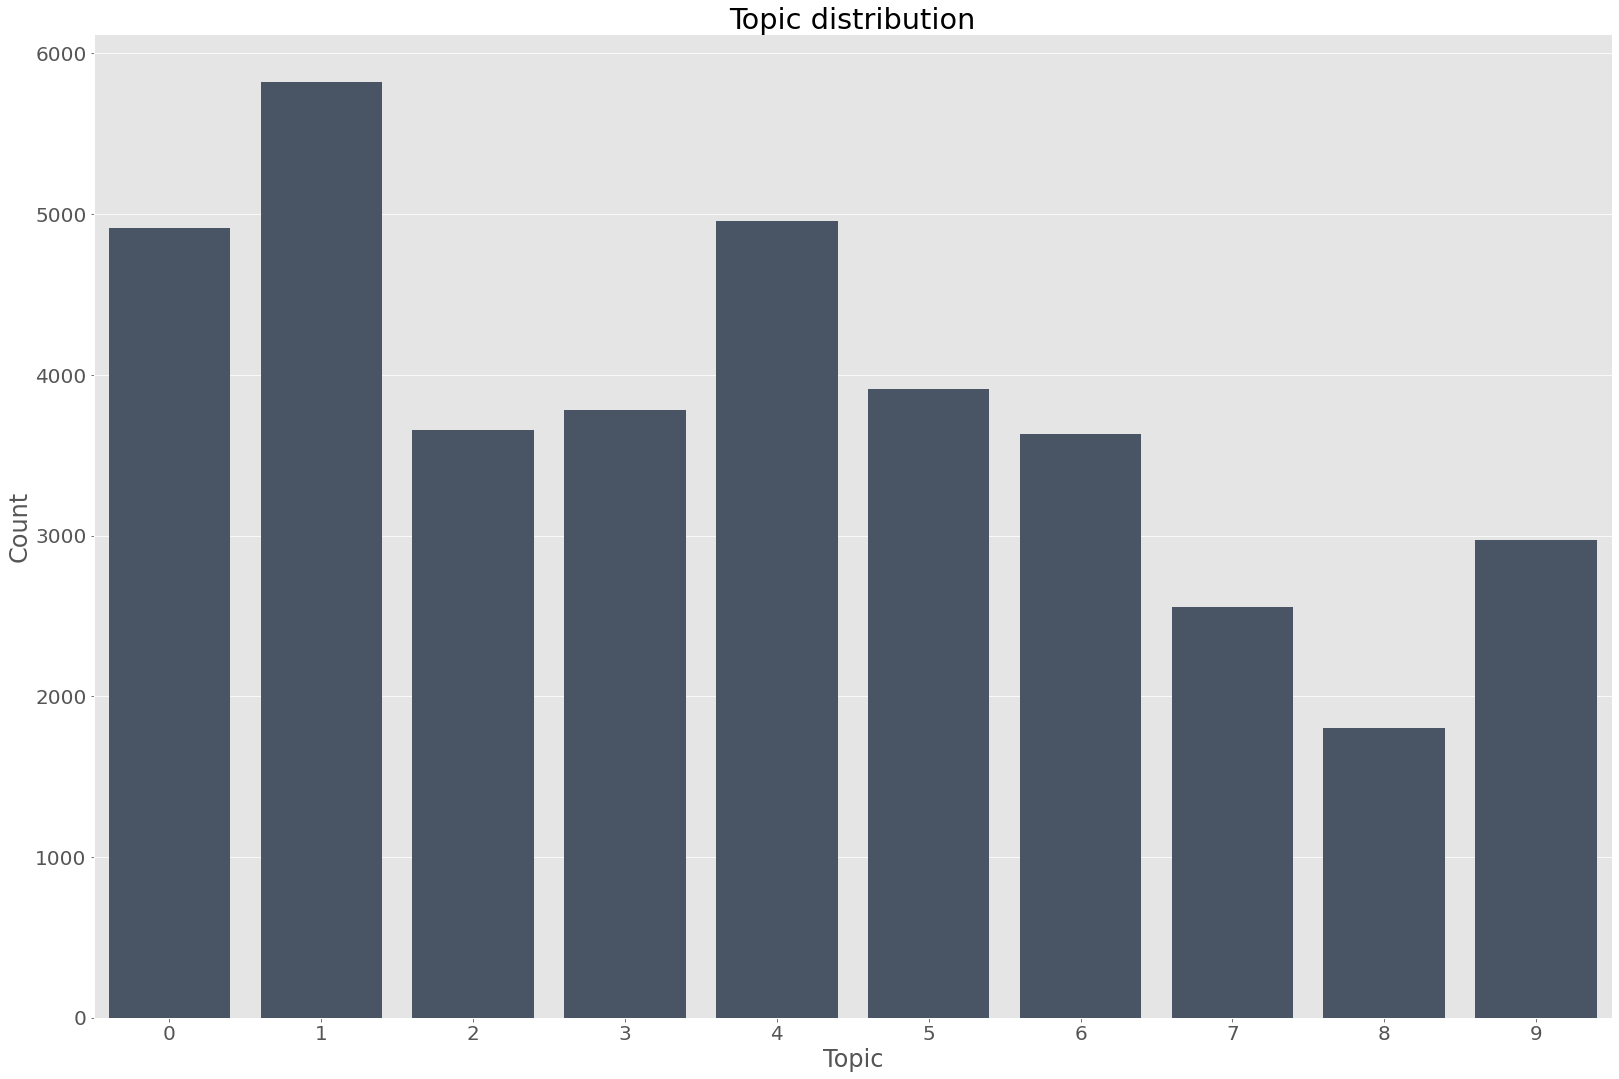

In [370]:
sns.catplot("topicNumber", kind="count", color="#44546A", height=15, 
            aspect=1.5, data=topics).set(title = 'Topic distribution',
                                      xlabel = 'Topic', 
                                      ylabel = 'Count');

We can also check how these scores vary within topics. `Seaborn` has some nice graphical options to represent continuous data within categories. We experiment with the `swarm` and `boxen` options (both represent the same data). The median scores for each topic seem to lie between 0.6 and 0.8. These is considerable variability, however. 

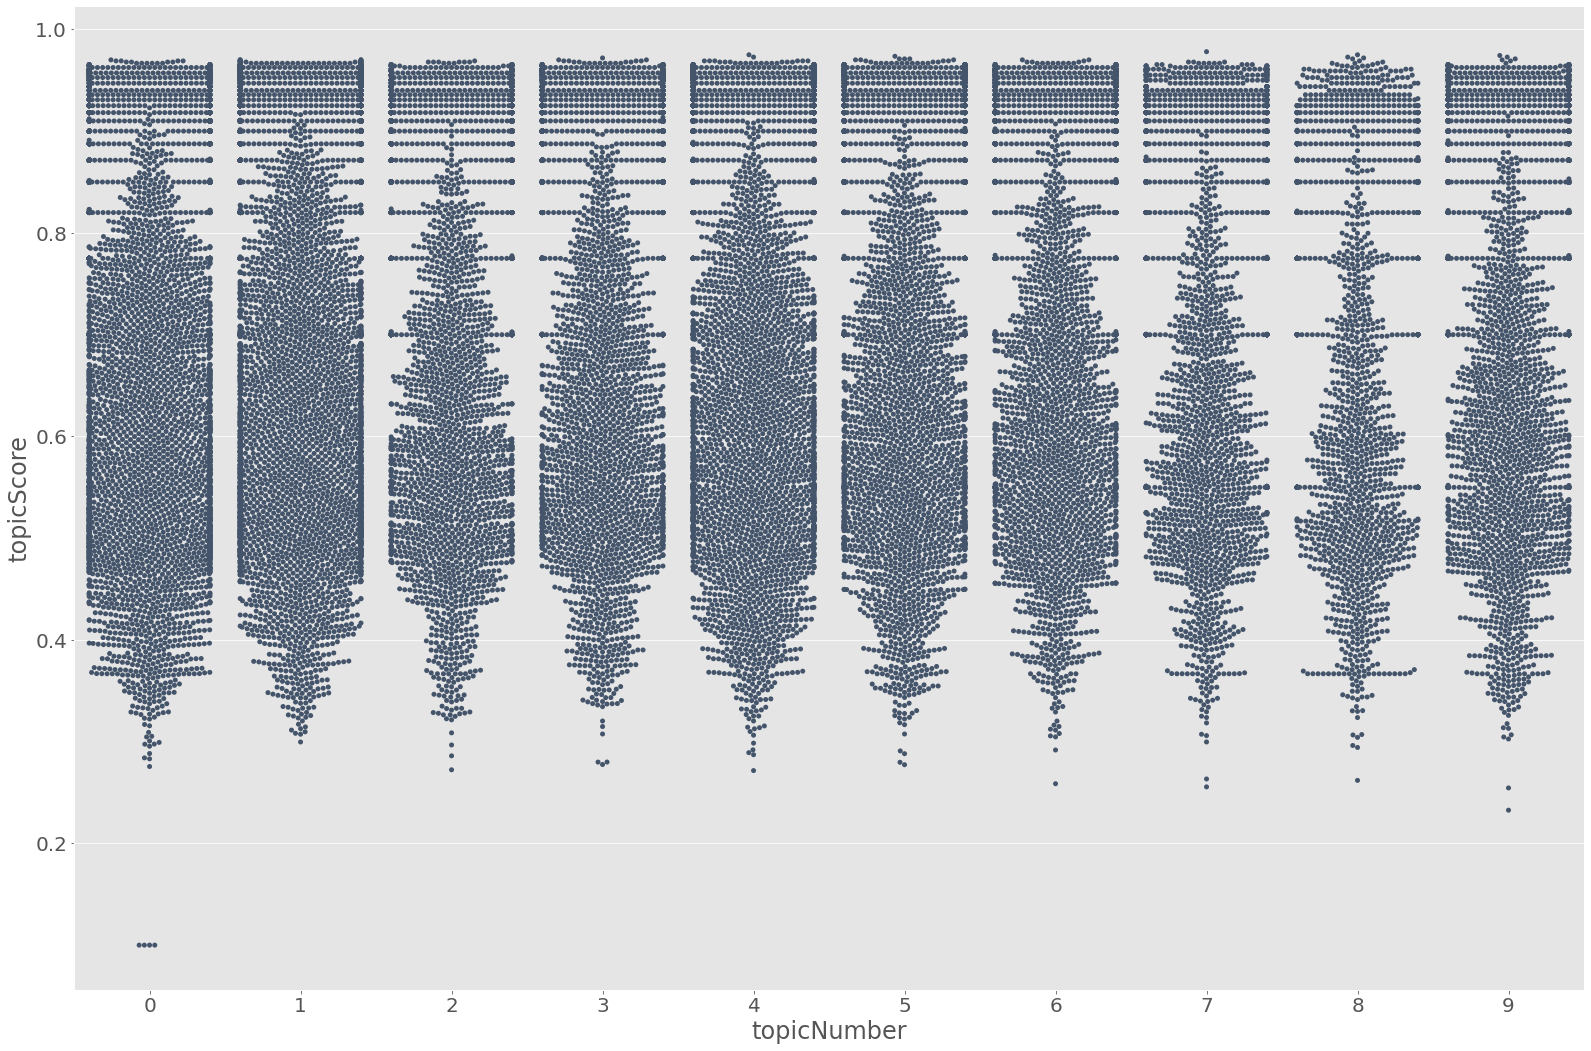

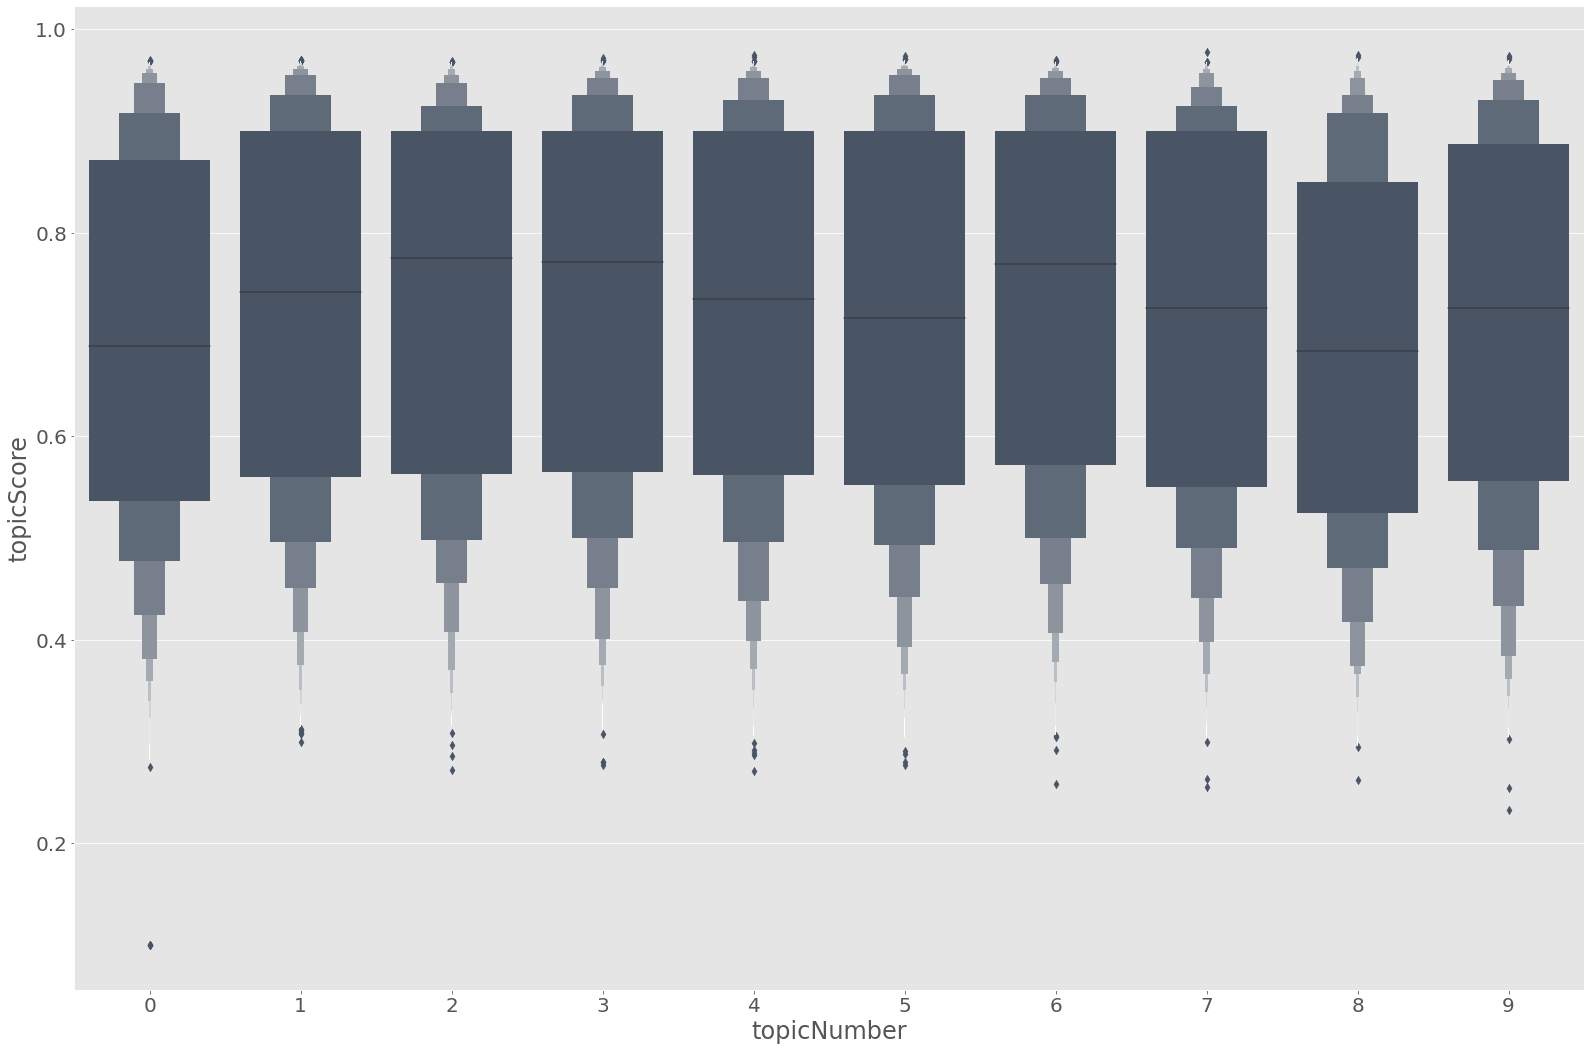

In [371]:
sns.catplot(x="topicNumber", y="topicScore", color="#44546A", height=15, 
            aspect=1.5, kind="swarm", data=df3);

sns.catplot(x="topicNumber", y="topicScore", color="#44546A", height=15, 
            aspect=1.5, kind="boxen", data=df3);

### Sentiment analysis

In this part we will have look at the sentiment of our tweets. To do so, we will make use of the `pattern.nl` library which allows us to obtain sentiment scores in terms of polarity and objectivity. For the sake of brevity, we will only focus on polarity wich is a score that can vary between -1 and 1. A negative score on a sentence implies that there are more negative words than positive words and vice versa. The word scores can be accessed <a href= "https://github.com/clips/pattern/tree/master/pattern/text/nl"> here. </a>

In [372]:
sentiment_score = [pattern.nl.sentiment(i) for i in word_tokens_]  # compute sentiment scores
polarity = [i[0] for i in sentiment_score]  # polarity score

So let's start with computing the sentiment scores and by having a look at their distribution. <br><br>
It seems that we have a lot of zero scores. It could be that a lot of tweets are neutral in sentiment but another option could be that a lot of words are not in the pattern.nl library. 

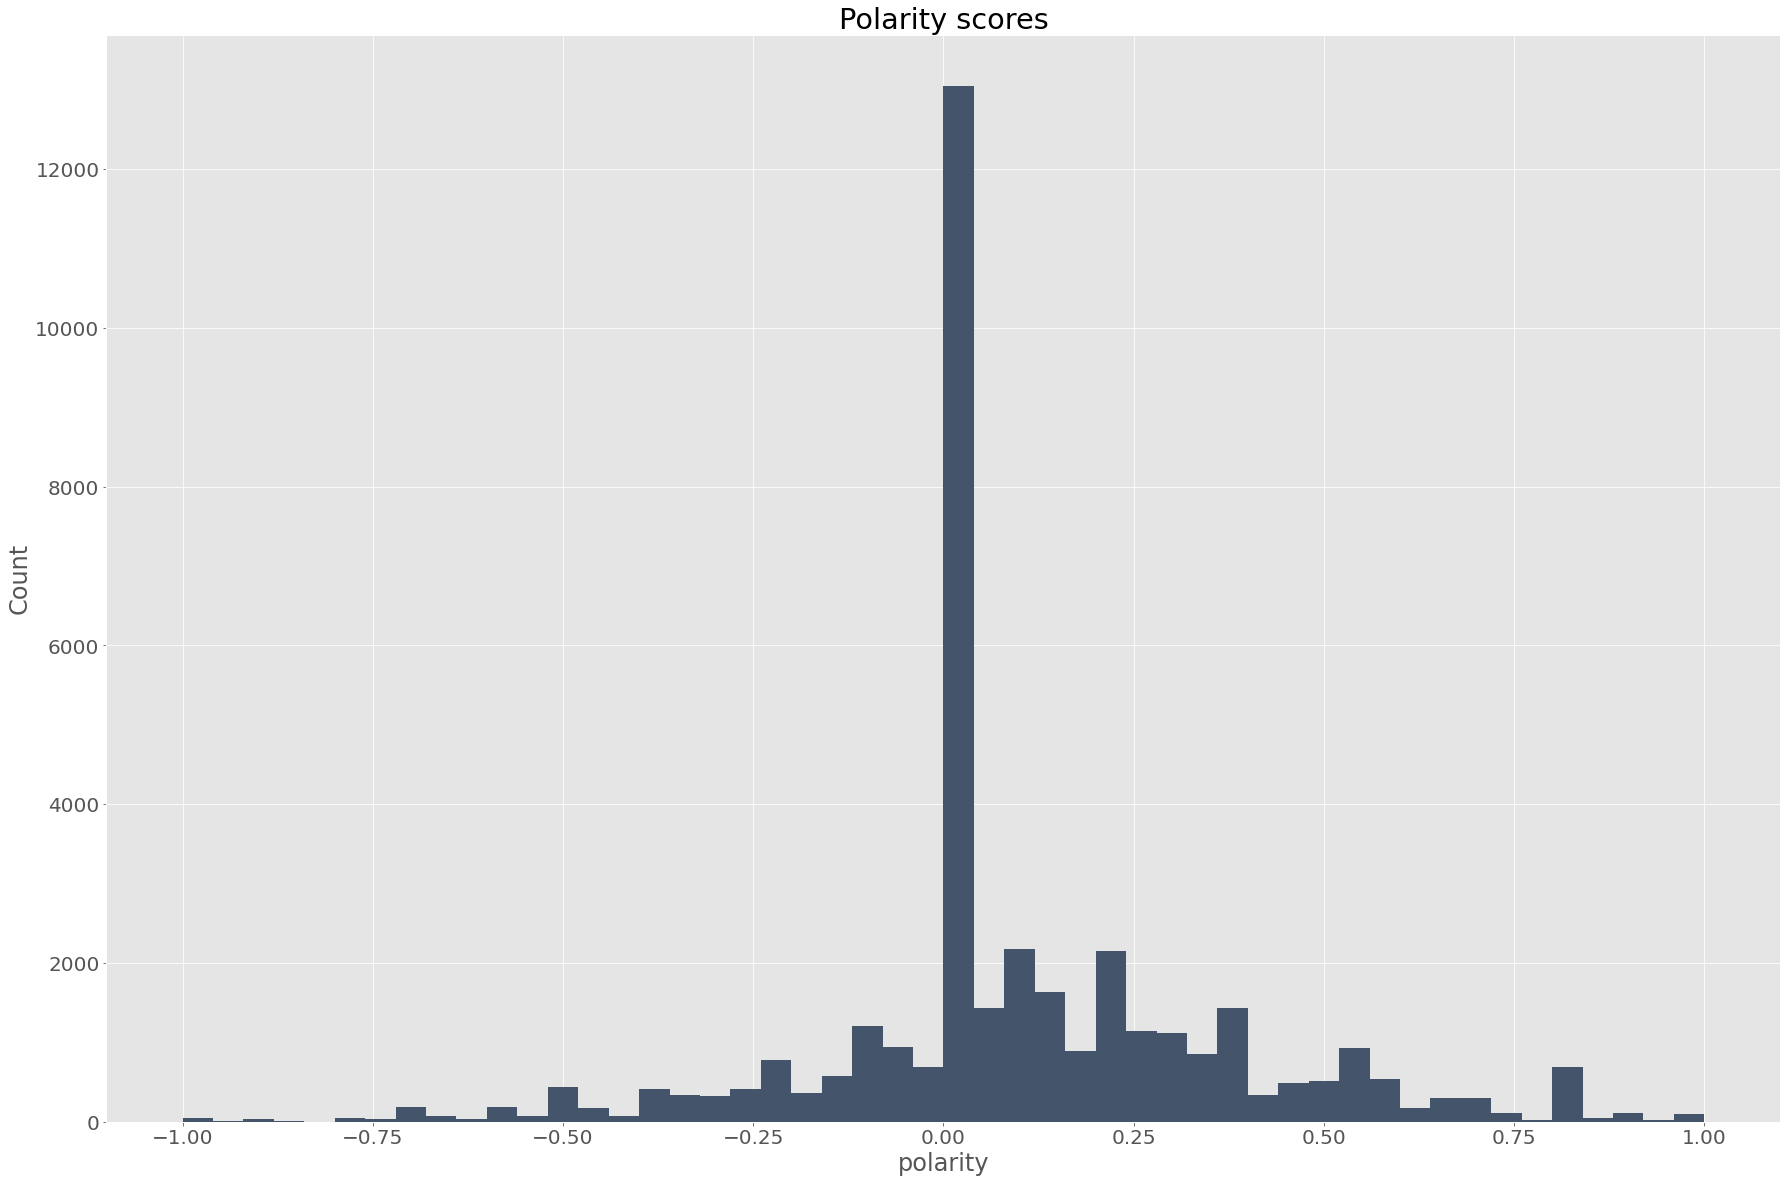

In [373]:
#plot sentiment scores
sns.distplot(polarity, kde=False, color="#44546A",
             hist_kws={"alpha":1}
            ).set(title = 'Polarity scores',
                                      xlabel = 'polarity', 
                                      ylabel = 'Count');


To check the number of words in the `pattern.nl` library, we import the xml file and count the number of words. The library containt 3304 words. So it would make little sense to use tweets in our analysis where none of the words are represented in the library. 

In [374]:
import pandas as pd 
import xml.etree.ElementTree as etree

tree = etree.parse("nl-sentiment.xml")
root = tree.getroot()
columns = ["word form", "cornetto_id", "cornetto_synset_id", 
           "wordnet_id", "pos", "sense", "polarity","subjectivity","intensity","confidence"]
words_pattern = [i.items()[0][1] for i in root.getchildren()]
words_pattern = [i.lower() for i in words_pattern]
print(len(set(words_pattern)))
d_pattern = set(words_pattern)

3304


We remove all the tweets that cannot have a sentiment score:

In [375]:
has_sentiment = []
for i in df3.tokens:
    if len(set(i.split(' ')).intersection(d_pattern)) == 0:
        has_sentiment.append('0')
    else:
        has_sentiment.append(1)   
print("Number of tweets without sentiment is {}.Hence {} tweets have sentiment scores".format(sum(np.array(has_sentiment) == '0'), 
                                                                                               sum(np.array(has_sentiment) == '1')))

Number of tweets without sentiment is 9994.Hence 28010 tweets have sentiment scores


Let's have a look at the sentiment distribution now.

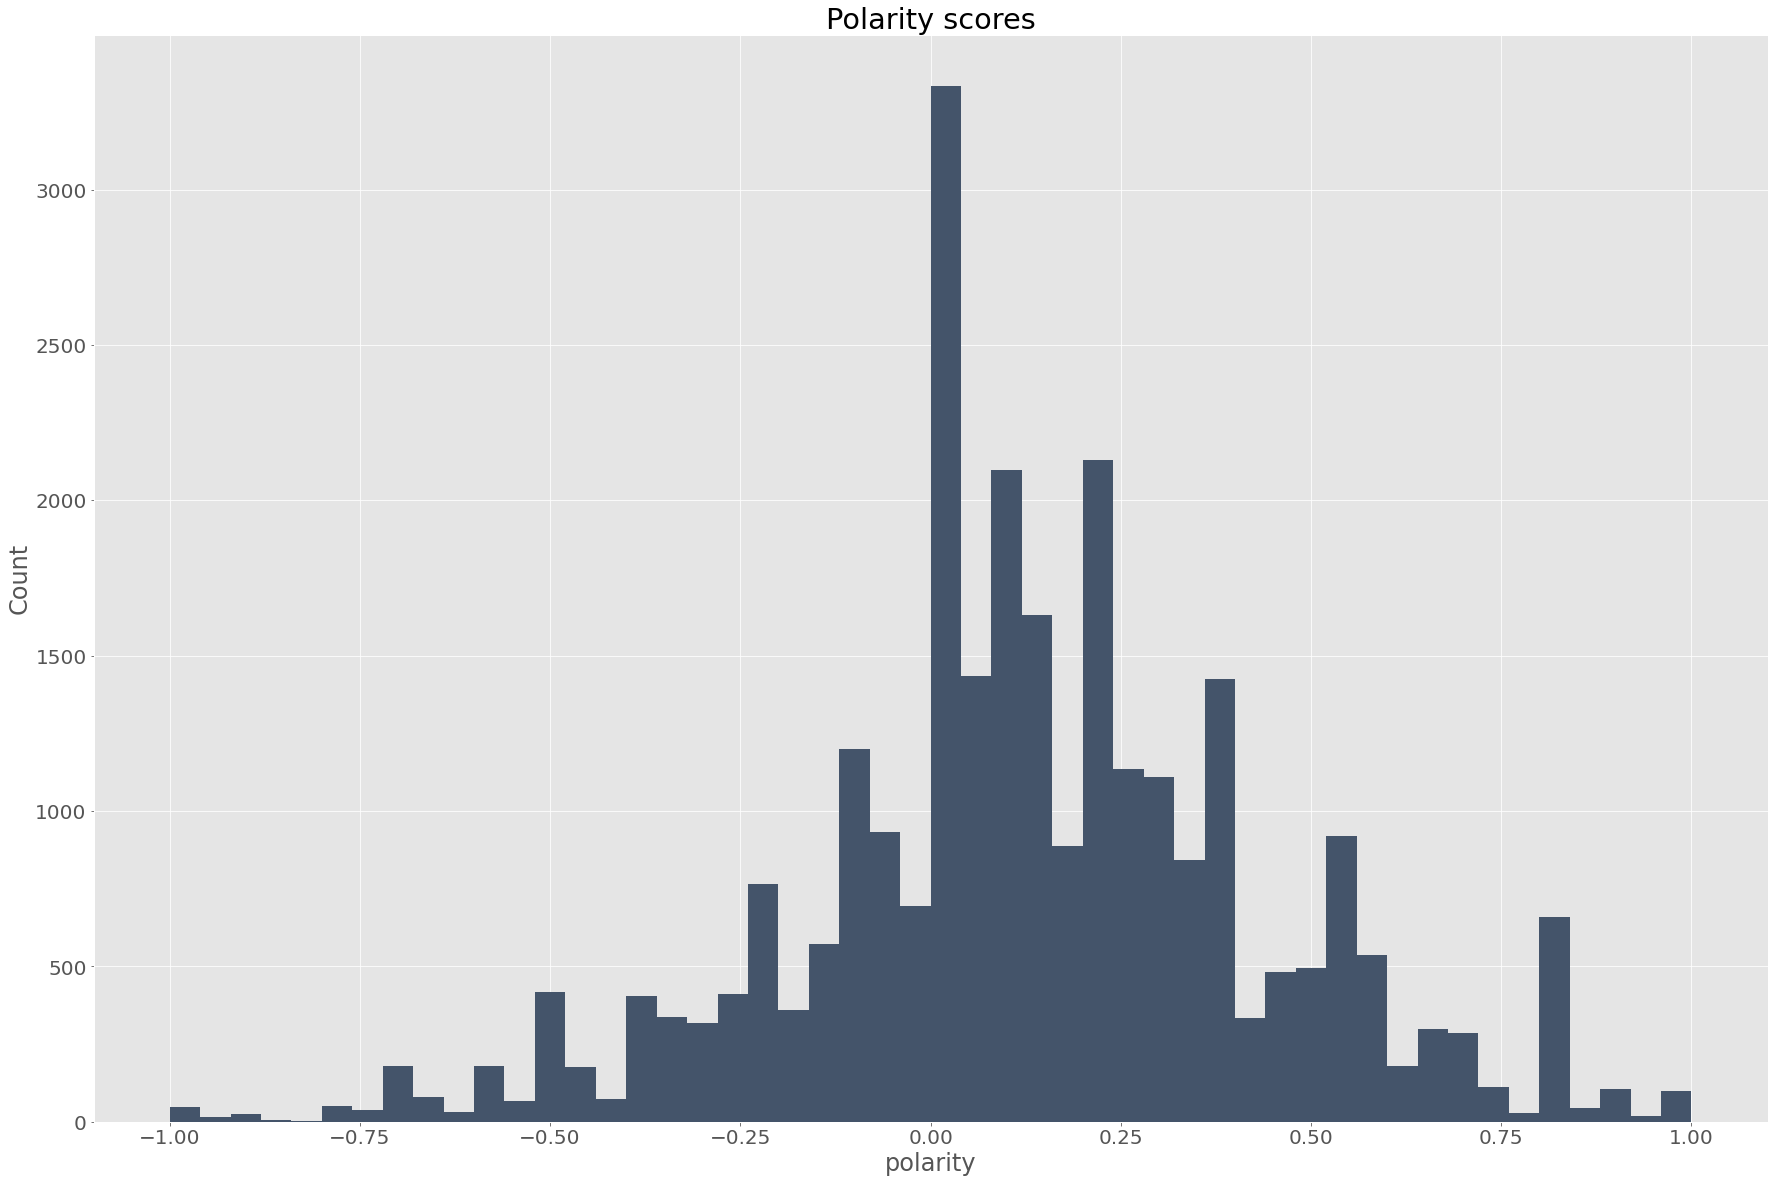

In [377]:
df4 = pd.concat([df3, pd.Series(polarity, name="polarity"),  pd.Series(has_sentiment, name="has_senti")], axis=1)
df5 = df4[df4.has_senti == 1]
sns.distplot(df5.polarity, kde=False, color="#44546A",
             hist_kws={"alpha":1}
            ).set(title = 'Polarity scores',
                                      xlabel = 'polarity', 
                                      ylabel = 'Count');

In [378]:
df3.tweet_date.unique()

array(['21-04', '22-04', '23-04', '24-04', '25-04', '26-04', '27-04',
       '28-04', '29-04', '30-04', '01-05', '02-05', '03-05'], dtype=object)

Now that we have sentiment scores for each of our tweets, we could look at different relations. We will look at:
- the evolution of sentiment over time (c.q. over the days in our dataset)
- the evolution of sentiment over time within different topic categories.

Using the seaborn `catplot` option we can plot sentiment by means of boxplots (`box`) or we can draw a line plot (`point`) to see how sentiment varies over time.

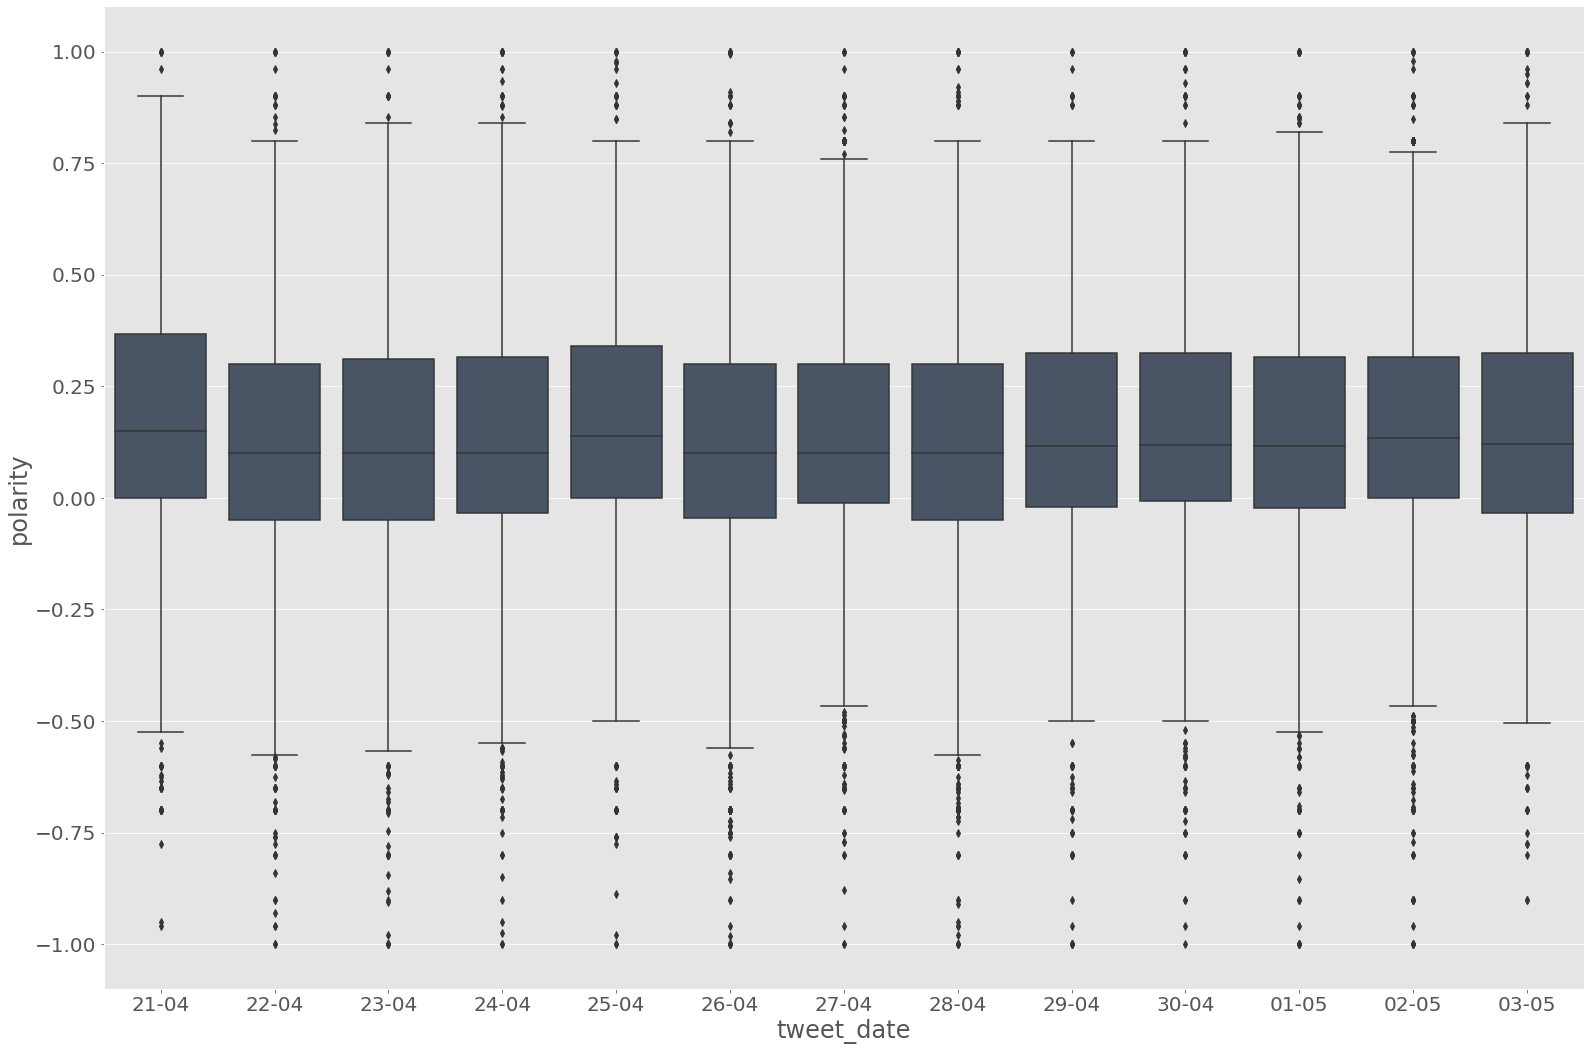

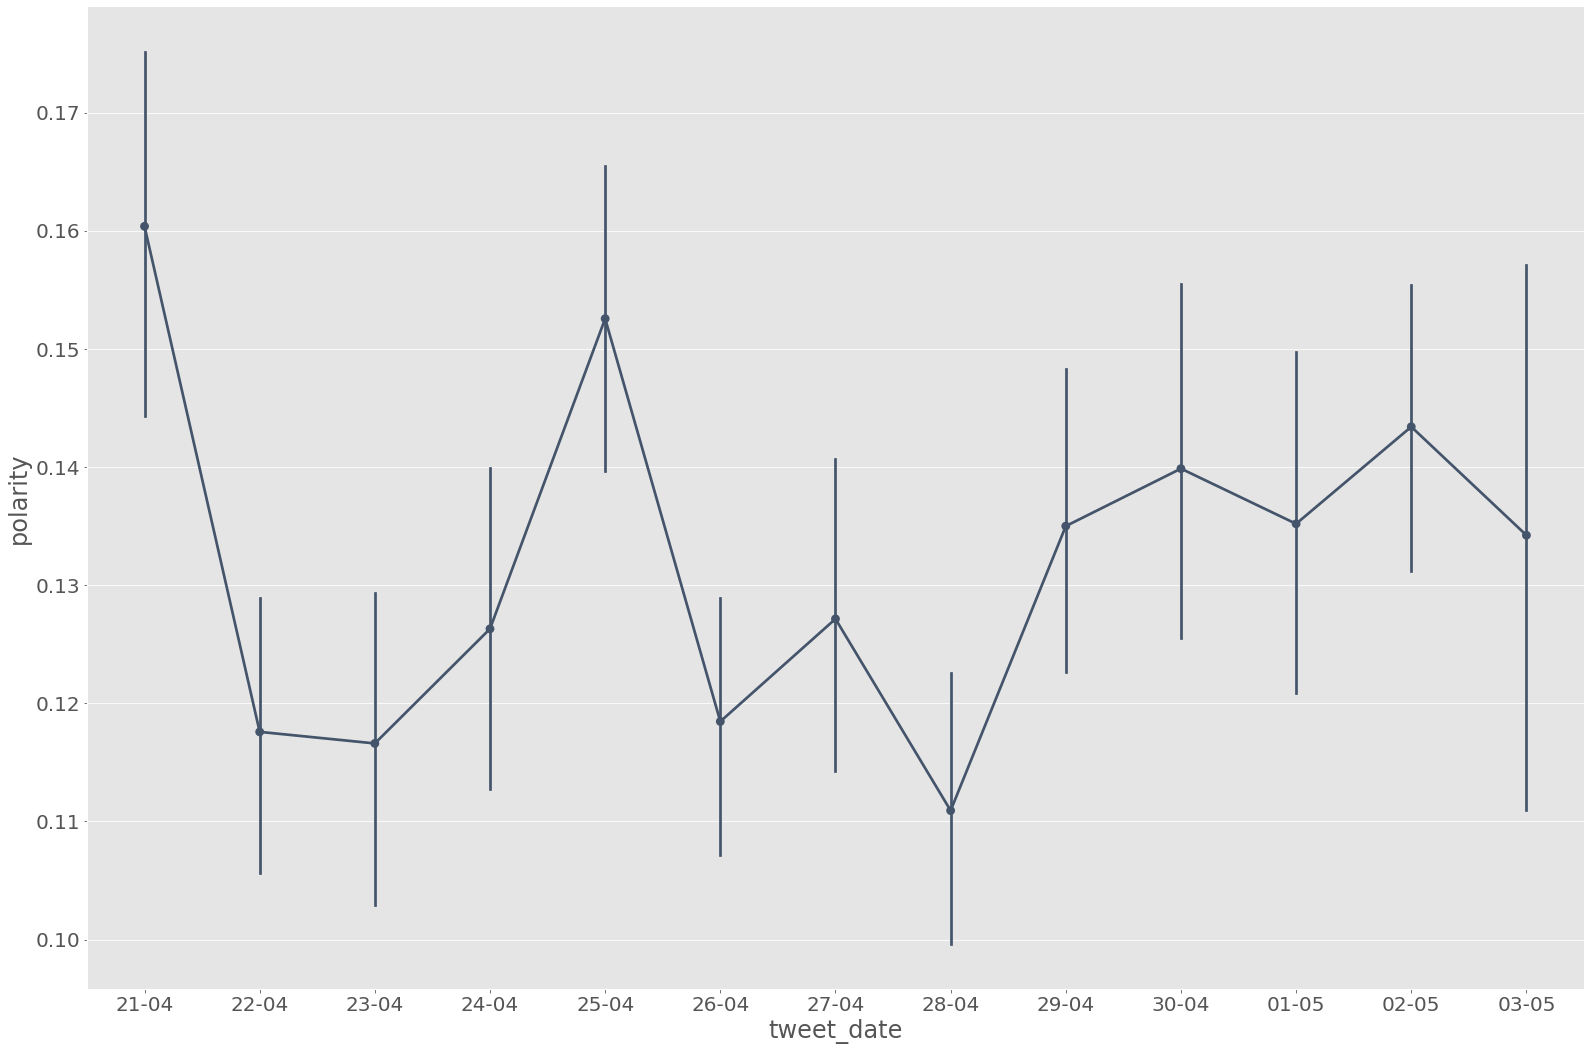

In [379]:
sns.catplot(x="tweet_date", y="polarity", color="#44546A", height=15, 
            aspect=1.5, kind="box", data=df5);
sns.catplot(x="tweet_date", y="polarity", color="#44546A", height=15, aspect=1.5, kind="point", data=df5);

Finally, we can draw a line plot that show the evolution of sentiment over time for each topic category.

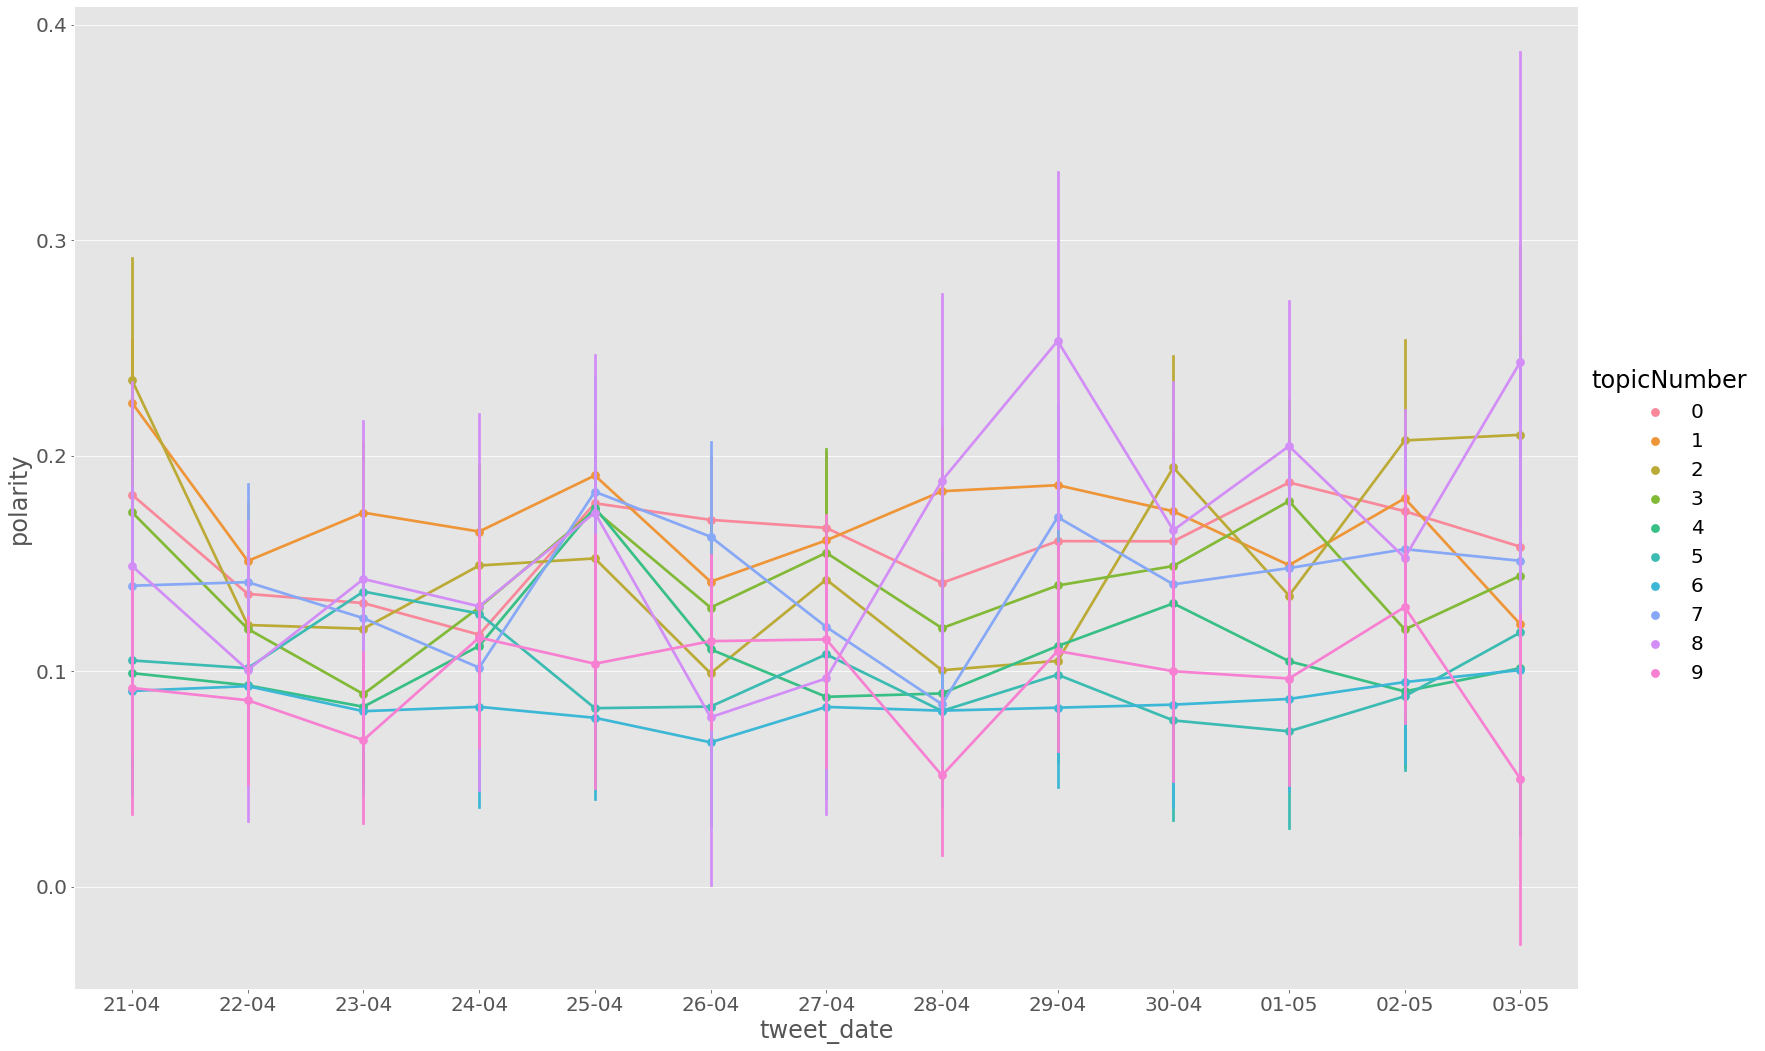

In [380]:
sns.catplot(x="tweet_date", y="polarity",  height=15, hue="topicNumber",
            aspect=1.5, kind="point", data=df5);

### Co-hashtag analysis

In this final part, we will have a look at how the hastags used in our tweets connect to each other. More specifically, we will use some social network analysis methods (`networkx` library) to see which hashtags occur the most together.

In [381]:
import networkx as nx
import itertools

First, we write a custom function to extract hashtags from our tweets. Of course, we exclude #lockdown from those hashtags as it was our keyword we searched on to begin with. In addition, we also remove duplicate tweets. 

In [382]:
def extract_hashtags(text):
    hashtags= []
    t = text.split(' ')
    for i in t:
        if '#' in i:
            tag = i.lower()
            if 'lockdown' not in tag:
                hashtags.append(tag[1:])
    return hashtags
#remove doubles in text
df6 = df4.drop_duplicates(subset='text')
temp_text = df6.text
to_replace = dict({'\n': ' '})
temp_text = [replace_characters(to_replace, i) for i in temp_text]

In [383]:
print("number of tweets including duplicates is {}. After removal, {} tweets remain".format(len(df4), len(df6)))

number of tweets including duplicates is 38004. After removal, 38004 tweets remain


In [384]:
hashtags = []
for i in temp_text:
    tags = extract_hashtags(i) 
    if len(tags) > 0:
        hashtags.append(tags)
# create hashtags combinations of size 2
all_tuples = []
for tags in hashtags:
    for i in itertools.combinations(tags, 2):
        all_tuples.append(i)
#remove hashtags that never co-occur with other hashtags        
to_drop = []
for index, i in enumerate(all_tuples):
    if i[0] ==  '':
        to_drop.append(index)
for index in sorted(to_drop, reverse=True):
    del all_tuples[index]

Let's have a look ath the first 10 hashtag combinations.

In [385]:
x = pd.Series(all_tuples)
x[1:10]


1                   (tinder, coronavirus)
2                  (covid19, coronavirus)
3                      (mondmaskers, dtv)
4                    (mondmaskers, begov)
5               (mondmaskers, covid19be…)
6                            (dtv, begov)
7                       (dtv, covid19be…)
8                     (begov, covid19be…)
9    (persconferentie, coronamaatregelen)
dtype: object

Now, we create a nework object using the `networkx` library. We determine the weigth of the edges by looking how many times specific hashtag combinations appear. As we have a lot of hashtag combiunations, our network visualisation would blow up very quickly. Therefore, we only include nodes if two nodes have at least on relation with weigth 15 or more. Put differently, a hashtag combination should appear at least twelve times in our dataset before being included.  

In [386]:
p = x.groupby(by=x).size()
edgelist = []
for index_, i in enumerate(p):
    t = p.index[index_]
    if i > 15:
        edgelist.append([t[0], t[1], i])
G = nx.Graph()
for index, i in enumerate(edgelist):
    G.add_edge(edgelist[index][0], edgelist[index][1], weigth = edgelist[index][2])

In [387]:
print("Our network has {} edges and {} nodes".format(G.number_of_edges(),G.number_of_nodes()))

Our network has 66 edges and 35 nodes


Creating a graphical representation is done through the `draw_network()` function. 

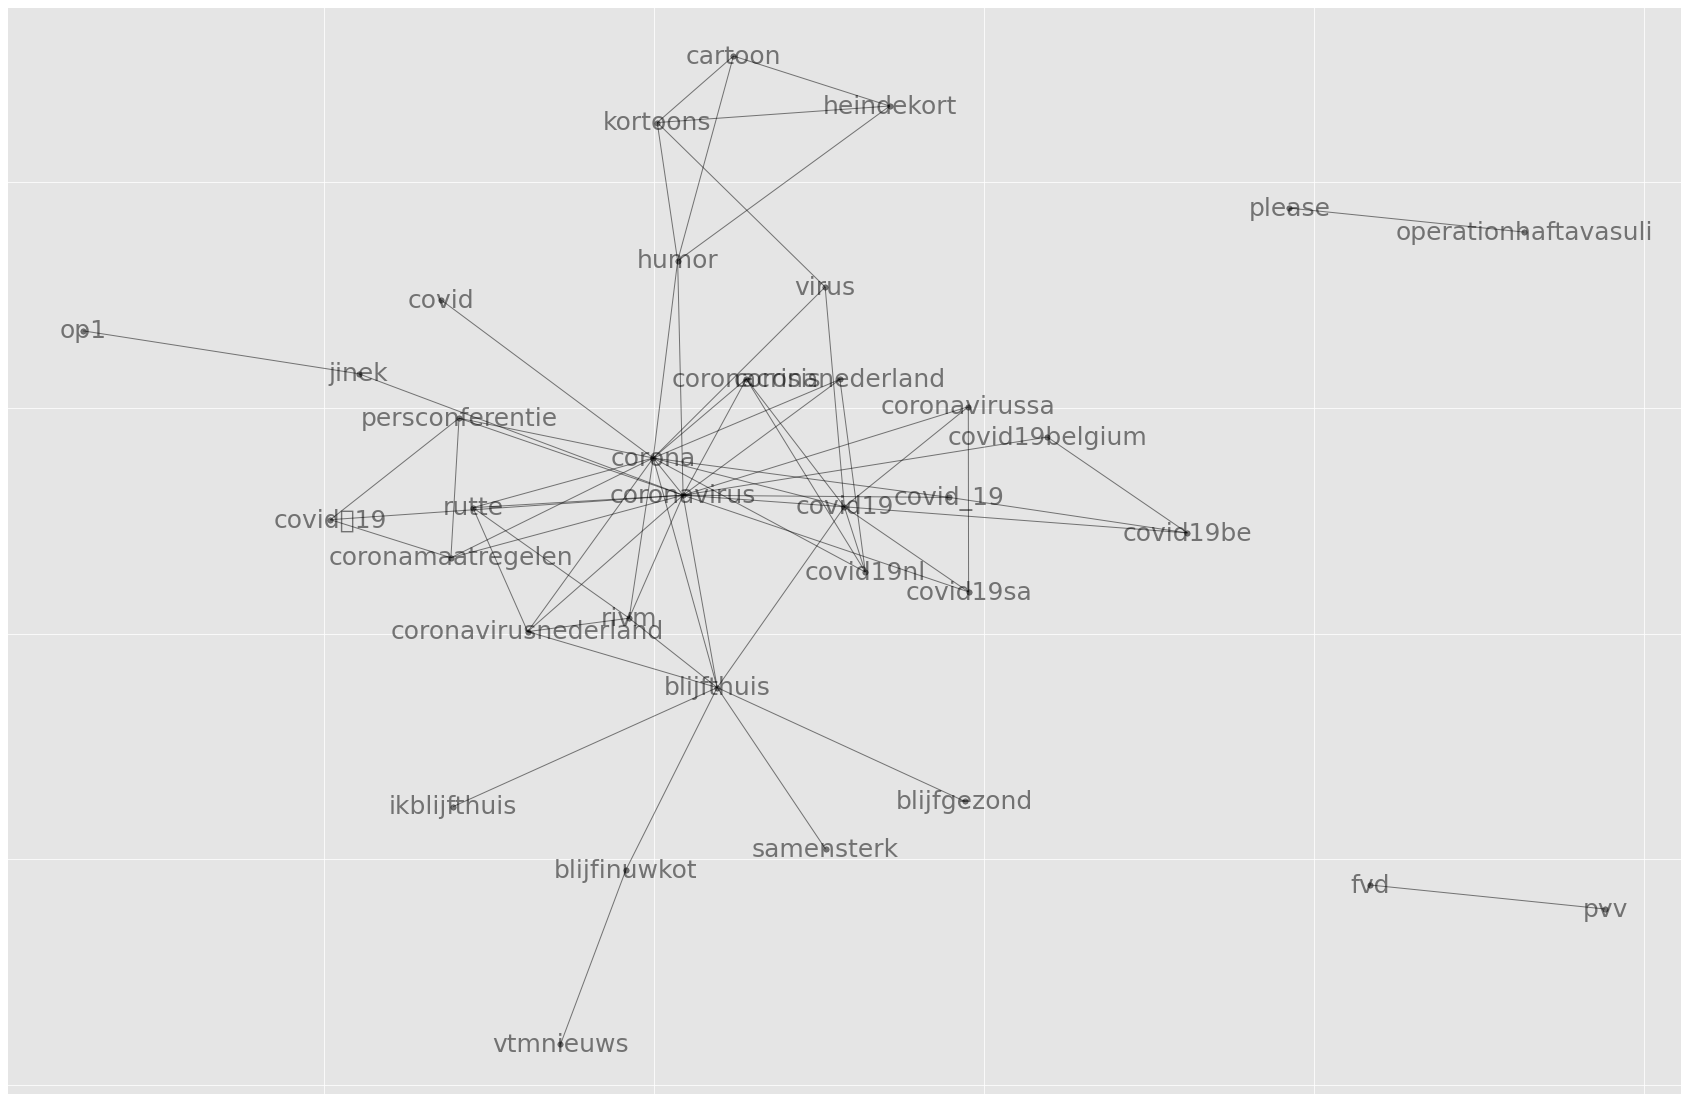

In [392]:
pos = nx.layout.spectral_layout(G)
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos=nx.nx_agraph.graphviz_layout(G), node_color='k', alpha=0.5, font_size=25, node_size=30)
plt.savefig("Graph.png", format="PNG")

We can look at the individual words that make up the separate components using the `conncected_components` option.

In [389]:
for i in nx.components.connected_components(G):
    print(i) 

{'vtmnieuws', 'covid19be', 'rutte', 'virus', 'coronavirus', 'humor', 'heindekort', 'blijfthuis', 'ikblijfthuis', 'corona', 'kortoons', 'jinek', 'coronacrisis', 'covid19', 'samensterk', 'covid19belgium', 'coronamaatregelen', 'blijfinuwkot', 'covid', 'coronavirusnederland', 'covidー19', 'persconferentie', 'cartoon', 'op1', 'blijfgezond', 'covid19sa', 'covid_19', 'rivm', 'coronavirussa', 'coronanederland', 'covid19nl'}
{'pvv', 'fvd'}
{'please', 'operationhaftavasuli'}


Finally, we can have a look at the words with the highest degree. In this case, this would mean those words that have the most combinations with other hashtags (with a weigth of at least 12).

In [390]:
pd.DataFrame(list(G.degree()), columns = ["hashtag", "degree"]).sort_values(by="degree", ascending=False)[1:10]

,hashtag,degree
3,corona,15
0,blijfthuis,9
11,covid19,9
14,rivm,5
27,humor,5
5,coronavirusnederland,5
29,kortoons,4
7,coronacrisis,4
8,coronamaatregelen,4
